In [10]:
pip install chromadb faiss-cpu sentence-transformers transformers pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 10.2 MB/s eta 0:00:00


In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import chromadb
import pinecone
import faiss
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [28]:
# Sample data with more specific information
documents = [
    "The dense forest near Oakville contains many species of wildlife including foxes, deer, and owls.",
    "Last Tuesday, a wildfire broke out in the eastern part of the forest, causing animals to flee westward.",
    "Park rangers reported seeing a family of foxes hiding in burrows near the creek to escape the smoke.",
    "Local conservation efforts are focused on rehabilitating injured animals from the affected forest areas.",
    "Scientists have documented that the forest ecosystem is slowly recovering one month after the fire."
]
query = "What happened to the foxes in the forest?"

In [6]:
# Initialize embedding model
print("Loading embedding model...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedder.encode(documents)
embedding_dim = embeddings.shape[1]
query_embedding = embedder.encode([query])[0]


Loading embedding model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
print("Loading TinyLlama model...")
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Loading TinyLlama model...


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

In [8]:
# Helper function for generating responses from TinyLlama
def generate_response(prompt, max_length=100):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response

In [29]:
# --- ChromaDB Setup ---
print("Setting up ChromaDB...")
import chromadb
from chromadb.errors import ChromaError, InternalError

chroma_client = chromadb.Client()

try:
    collection = chroma_client.create_collection(name="demo_collection")
    print("Collection 'demo_collection' created.")
except InternalError as e:
    if "already exists" in str(e):
        print("Collection already exists. Retrieving existing collection...")
        collection = chroma_client.get_collection(name="demo_collection")
    else:
        raise e  # Re-raise if it's a different error

# Add documents
chroma_ids = [str(i) for i in range(len(documents))]
collection.add(
    documents=documents,
    embeddings=embeddings.tolist(),
    ids=chroma_ids
)

# --- FAISS Setup ---
print("Setting up FAISS...")
faiss_index = faiss.IndexFlatL2(embedding_dim)
faiss_index.add(embeddings)

Setting up ChromaDB...
Collection 'demo_collection' created.
Setting up FAISS...


In [30]:
# --- Query and Measure Time ---
# ChromaDB Query
start_time = time.time()
chroma_results = collection.query(query_embeddings=[query_embedding.tolist()], n_results=2)
chroma_time = time.time() - start_time
chroma_context = [documents[int(id)] for id in chroma_results['ids'][0]]

# FAISS Query
start_time = time.time()
distances, indices = faiss_index.search(query_embedding.reshape(1, -1), 2)
faiss_time = time.time() - start_time
faiss_context = [documents[idx] for idx in indices[0]]

print("\nRetrieved Context:")
print("ChromaDB retrieved:", chroma_context)
print("FAISS retrieved:", faiss_context)


Retrieved Context:
ChromaDB retrieved: ['Last Tuesday, a wildfire broke out in the eastern part of the forest, causing animals to flee westward.', 'Scientists have documented that the forest ecosystem is slowly recovering one month after the fire.']
FAISS retrieved: ['Last Tuesday, a wildfire broke out in the eastern part of the forest, causing animals to flee westward.', 'Scientists have documented that the forest ecosystem is slowly recovering one month after the fire.']


In [31]:
# --- RAG vs No-RAG Comparison ---
# RAG prompt with context
rag_prompt = f"""<human>
Context information:
{' '.join(chroma_context)}

Based ONLY on the context information above (not on any prior knowledge), {query}
</human>

<assistant>"""

# No-RAG prompt (direct question without context)
no_rag_prompt = f"""<human>
{query}
</human>

<assistant>"""

# Generate responses
print("\nGenerating responses...")
rag_response = generate_response(rag_prompt)
no_rag_response = generate_response(no_rag_prompt)



Generating responses...

--- RAG vs No-RAG Comparison ---
Query: What happened to the foxes in the forest?

RAG Response (with context):

The wildfire that broke out in the eastern part of the forest caused animals to flee westward, leading to the recovery of the forest ecosystem.

No-RAG Response (without context):

The foxes in the forest were hunted and killed by humans who were hunting for food. The humans believed that the foxes were a threat to their livestock, and they killed them for their meat. This led to the decline and eventual extinction of the fox population in the forest.

Performance Comparison (Query Time in Seconds):
ChromaDB: 0.0038 seconds
FAISS: 0.0003 seconds


In [32]:
print("\n--- RAG vs No-RAG Comparison ---")
print(f"Query: {query}")
print(f"\nRAG Response (with context):\n{rag_response}")
print(f"\nNo-RAG Response (without context):\n{no_rag_response}")

print("\nPerformance Comparison (Query Time in Seconds):")
print(f"ChromaDB: {chroma_time:.4f} seconds")
print(f"FAISS: {faiss_time:.4f} seconds")


--- RAG vs No-RAG Comparison ---
Query: What happened to the foxes in the forest?

RAG Response (with context):

The wildfire that broke out in the eastern part of the forest caused animals to flee westward, leading to the recovery of the forest ecosystem.

No-RAG Response (without context):

The foxes in the forest were hunted and killed by humans who were hunting for food. The humans believed that the foxes were a threat to their livestock, and they killed them for their meat. This led to the decline and eventual extinction of the fox population in the forest.

Performance Comparison (Query Time in Seconds):
ChromaDB: 0.0038 seconds
FAISS: 0.0003 seconds


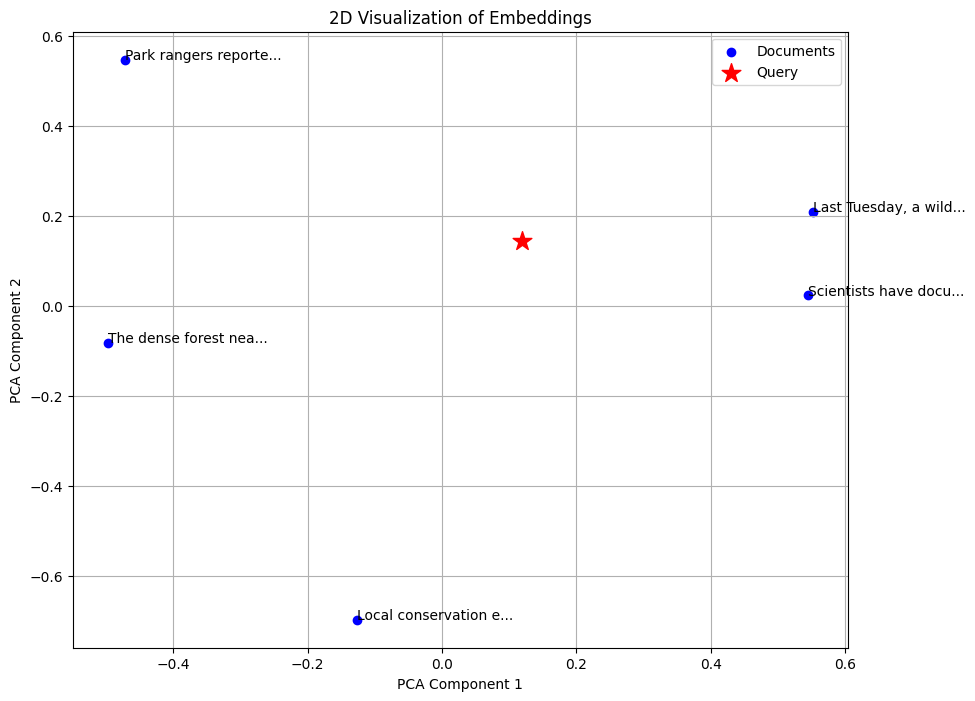

In [33]:
# --- Visualization ---
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
query_2d = pca.transform(query_embedding.reshape(1, -1))

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', label='Documents')
plt.scatter(query_2d[:, 0], query_2d[:, 1], c='red', marker='*', s=200, label='Query')
for i, txt in enumerate(documents):
    plt.annotate(txt[:20] + "...", (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title("2D Visualization of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.savefig('vector_embeddings.png')
plt.show()

# Clean up
chroma_client.delete_collection("demo_collection")